In this notebook we show how the CancerGrowthModel class is used, using examples and by providing some additional (background) information.

The easiest models to implement, are also the most simplified and less detailed ones. In the case of ODE's these would be the models describing linear and exponential growth.

We want to be able to have the user insert a dataset, containing tumor volume growth data over multiple timepoints, and then return the most likely ODE that describes the growth pattern to the user. First we start with a dataset:

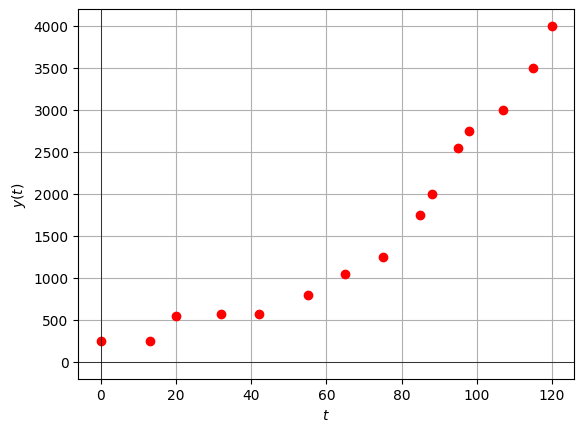

In [1]:
from matplotlib import pyplot as plt

ts_data = [0, 13, 20, 32, 42, 55, 65, 75, 85, 88, 95, 98, 107, 115, 120]
ys_data = [250, 255, 550, 575, 576, 800, 1050, 1250, 1750, 2000, 2550, 2750, 3000, 3500, 4000]

plt.plot(ts_data, ys_data, 'ro')
plt.axhline(0.0, lw=0.5, color='k'); plt.axvline(0.0, lw=0.5, color='k')
plt.grid(True)
plt.xlabel('$t$'); plt.ylabel('$y(t)$')
plt.show()

Now, after looking at the data we can import the CancerGrowthModel class to start fitting the ODE's onto the user-provided dataset. To do so, we use an ODE solver. An ODE describes how a quantity changes over time, in this case the volume of the tumor. Most ODE's can not be solved exactly, so they have to be approximated using an ODE solver. ODE solvers come in different types, where some might be more precise, but more complicated and others less precise and easier to implement. The class offers 3 different ODE solvers, Heun's, Euler's and Runge-Kutta. Where Runge-Kutta is known to be the most accurate. The exact question to solve is, given a set of data points, what are the optimal values of parameters for this data?

First we plot some ODE models with the data, to see if any ODE's match the shape of the data.

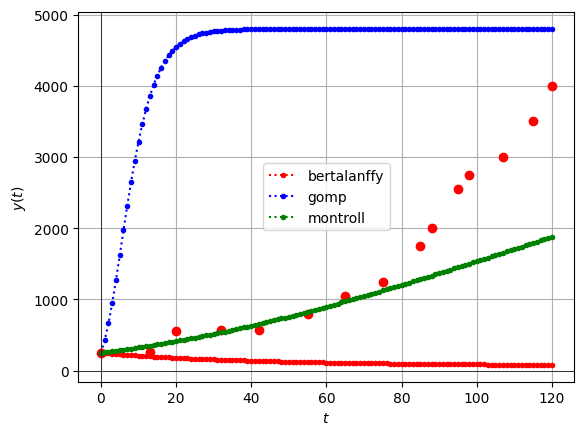

MSE Bertalanffy= 4.38e+05
MSE Gompertz= 5.40e+04
MSE Montroll= 3.96e+05


In [2]:
from cancergrowthmodel import CancerGrowthModel as cgm

# Estimate params, based on data
params = {
    'c':  0.2,
    'y0': ys_data[0],
    'ymax': ys_data[-1] * 1.2,
    'a': 0.05
}

model = cgm(start_size=1, t_end = 120)

ts_numer, ys_numer = model.compute_curve(model= "bertalanffy", solver = "runge-kutta", **params)
ts_numer_1, ys_numer_1 = model.compute_curve(model= "gompertz", solver = "runge-kutta", **params)
ts_numer_2, ys_numer_2 = model.compute_curve(model= "montroll", solver = "runge-kutta", **params)

plt.plot(ts_data, ys_data, 'ro')
plt.plot(ts_numer, ys_numer, '.:r', label='bertalanffy')
plt.plot(ts_numer_1, ys_numer_1, '.:b', label='gomp')
plt.plot(ts_numer_2, ys_numer_2, '.:g', label='montroll')

plt.axhline(0.0, lw=0.5, color='k'); plt.axvline(0.0, lw=0.5, color='k')
plt.grid(True); plt.legend()
plt.xlabel('$t$'); plt.ylabel('$y(t)$')
#plt.title(f'error$(t=1)$ = {ys_data[-1] - ys_numer[-1]:8.6f}')
plt.show()

print(f'MSE Bertalanffy= {model.MSE(model = "bertalanffy", ys_data=ys_data, **params):.2e}')

print(f'MSE Gompertz= {model.MSE(model = "gompertz", ys_data=ys_data, **params):.2e}')

print(f'MSE Montroll= {model.MSE(model = "montroll", ys_data=ys_data, **params):.2e}')



All MSE's seem pretty high, because the variables were estimated, we can improve this by fitting, using either random search (Monte Carlo) or direct search (Hooke & Jeeves).

## Random search

In [12]:
from random import gauss

# Initialisatie van onbekende waarden
params = {
    'c':  0.1,
    'y0': 250.0,
    'ymax': 5000.0,
    'a': 0.05
}

# Herhaaldelijke aanpassing
mse = model.MSE(model = "montroll", solver = "runge-kutta",ys_data=ys_data, **params)
tries = 0
while tries < 1000:
    tries += 1
    new_params = {key: val + gauss(sigma=0.01) for key, val in params.items()}
    new_mse = model.MSE("montroll", "runge-kutta",ys_data, **new_params)
    if new_mse < mse:
        params = new_params
        mse = new_mse
        tries = 0

In [13]:
print('Optimale parameters:')
for key, val in params.items():
    print(f'* {key:>2s} = {val:9.6f}')

Optimale parameters:
*  c =  0.254525
* y0 = 249.894967
* ymax = 4999.965948
*  a =  1.425142


## Direct Search

In [10]:
params = {
    'c':  0.1,
    'y0': ts_data[0],
    'ymax': 5000,
    'a': 0.05
}
deltas = {key: 1.0 for key in params}

# Herhaaldelijke aanpassing
mse = model.MSE(model = "montroll", ys_data=ys_data, **params)
while max(abs(delta) for delta in deltas.values()) > 1e-9:
    for key in params:
        new_params = params.copy()
        # Probeer de betreffende parameter the verhogen
        new_params[key] = params[key] + deltas[key]
        new_mse = model.MSE("montroll", "runge-kutta",ys_data, **new_params)
        if new_mse < mse:
            params = new_params
            mse = new_mse
            deltas[key] *= 1.2
            continue
        # Probeer de betreffende parameter the verlagen
        new_params[key] = params[key] - deltas[key]
        new_mse = model.MSE("montroll", "runge-kutta",ys_data, **new_params)
        if new_mse < mse:
            params = new_params
            mse = new_mse
            deltas[key] *= -1.2
            continue
        # Verklein de stapgrootte
        deltas[key] *= 0.2

In [11]:
print('Optimale parameters:')
for key, val in params.items():
    print(f'* {key:>2s} = {val:9.6f}')

Optimale parameters:
*  c =  0.309905
* y0 = 229.966623
* ymax = 6405.247078
*  a =  0.735985


While being easy to implement, the linear and exponential models do not keep in account any surrounding variables, such as the maximum tumor size or keep in account that growth should be in relation to volume. So likely they do not give a good representation of real life tumor growth. Luckily there are other models that can be implemented, that do take these extra variables into account, making the predictions more realistic. The exponential flattening model is similar to the exponential model, but uses a maximum tumor size variable, where tumor growth slows down the closer it gets to the maximum size.

In [9]:
from cancergrowthmodel import CancerGrowthModel as cgm

# Generating prediction according to linear growth
linear_model = cgm(model = "montroll",
                   start_size = 1,
                   t_0 = 0,
                   t_end = 3,
                   growth_rate = 1.2)
linear_prediction = linear_model.predict()
print("Linear model prediction:", linear_prediction)

t_s, y_s = linear_model.ode_solver("heun")

linear_model.plot(linear_prediction, t_s=t_s, y_s=y_s)

# Generating prediction according to exponential growth
# exponential_model = cgm(model = "exponential_incr",
#                         start_size = 1,
#                         t_0 = 0,
#                         t_end = 15,
#                         growth_rate = 1.2)
# exponential_incr_prediction = exponential_model.predict()
# print("Exponential incr model prediction:", exponential_incr_prediction)
# exponential_model.plot(exponential_incr_prediction)

KeyError: 'montroll'

exponential_flat [1, 1.96, 2.69, 3.244, 3.666, 3.986, 4.229, 4.414, 4.555, 4.662, 4.743, 4.805, 4.851, 4.887, 4.914, 4.935, 4.95, 4.962, 4.971, 4.978, 4.983]
Exponential flattening model prediction: [1, 1.96, 2.69, 3.244, 3.666, 3.986, 4.229, 4.414, 4.555, 4.662, 4.743, 4.805, 4.851, 4.887, 4.914, 4.935, 4.95, 4.962, 4.971, 4.978, 4.983]


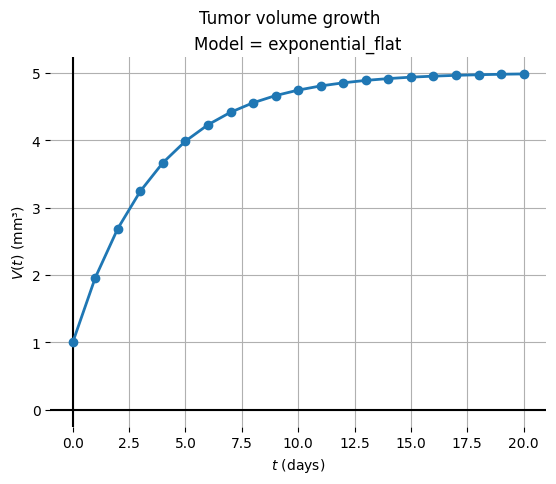

In [2]:
# Generating prediction according to exponential flattening growth
exponential_flattening_model = cgm(model = "exponential_flat",
                                   start_size = 1,
                                   t_0 = 0,
                                   t_end = 20,
                                   growth_rate = 1.2,
                                   step_size = 1,
                                   max_size = 5)
exponential_flattening_prediction = exponential_flattening_model.predict()
print("Exponential flattening model prediction:", exponential_flattening_prediction)
exponential_flattening_model.plot(exponential_flattening_prediction)


logistic [1, 2.17, 4.633, 9.548, 18.271, 30.181, 39.072, 40.16, 39.967, 40.007, 39.999, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]
Logistic model prediction: [1, 2.17, 4.633, 9.548, 18.271, 30.181, 39.072, 40.16, 39.967, 40.007, 39.999, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]


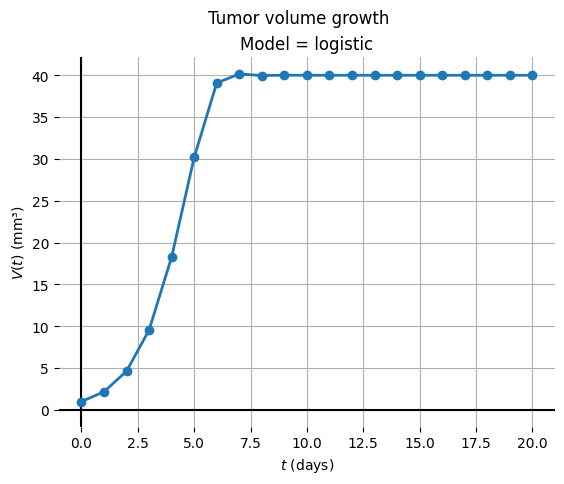

In [3]:
# Generating prediction according to logistic growth
logistic_model = cgm(model = "logistic",
                     start_size = 1,
                     t_0 = 0,
                     t_end = 20,
                     growth_rate = 1.2,
                     step_size = 1,
                     max_size = 40)
logistic_model_prediction = logistic_model.predict()
print("Logistic model prediction:", logistic_model_prediction)
logistic_model.plot(logistic_model_prediction)


allee [10, 14.5, 21.767, 30.939, 37.99, 39.979, 40.001, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]
Allee model prediction: [10, 14.5, 21.767, 30.939, 37.99, 39.979, 40.001, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0]


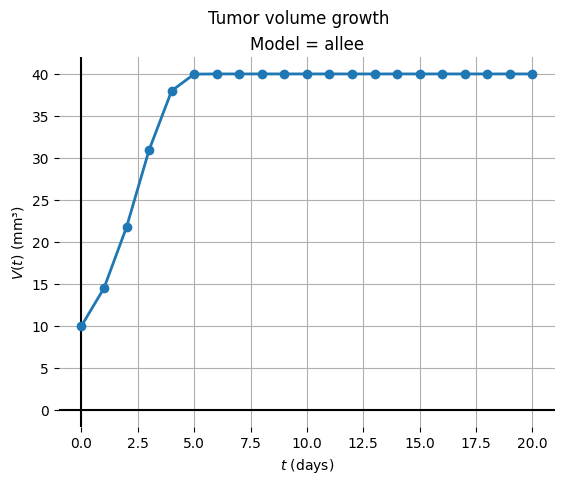

In [4]:
# Generating prediction according to allee growth
allee_model = cgm(model = "allee",
                  start_size = 10,
                  t_0 = 0,
                  t_end = 20,
                  growth_rate = 1.2,
                  step_size = 1,
                  max_size = 40,
                  min_size = 5)
allee_prediction = allee_model.predict()
print("Allee model prediction:", allee_prediction)
allee_model.plot(allee_prediction)


mendelsohn [1, 1.5, 2.419, 4.299, 8.756, 21.712]
Mendelsohn model prediction: [1, 1.5, 2.419, 4.299, 8.756, 21.712]


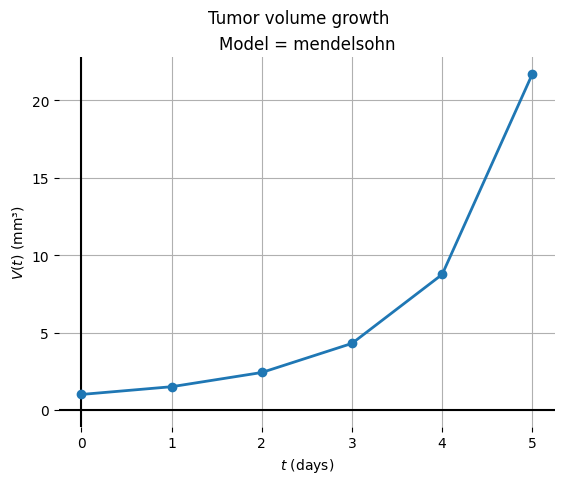

In [10]:
# Generating prediction according to Mendelsohn growth
# Still have to fix this
mendelsohn_model = cgm(model = "mendelsohn",
                       start_size = 1,
                       t_0 = 0,
                       t_end = 5,
                       growth_rate = 0.5,
                       step_size = 1,
                       a = 1.5)
mendelsohn_prediction = mendelsohn_model.predict()
print("Mendelsohn model prediction:", mendelsohn_prediction)
mendelsohn_model.plot(mendelsohn_prediction)

Montroll model prediction: [1, 1.484, 2.184, 3.164, 4.465, 6.031, 7.634, 8.905, 9.616, 9.89, 9.971]


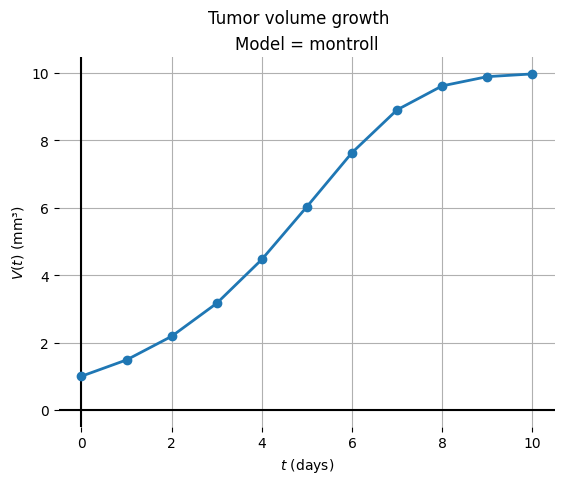

In [2]:
# Generating prediction according to Montroll growth
montroll_model = cgm(model = "montroll",
                       start_size = 1,
                       t_0 = 0,
                       t_end = 10,
                       growth_rate = 0.5,
                       step_size = 1,
                       a = 1.5,
                       max_size = 10)
montroll_prediction = montroll_model.predict()
print("Montroll model prediction:", montroll_prediction)
montroll_model.plot(montroll_prediction)

linear_limited [1, 1.2, 1.422, 1.666, 1.929, 2.21, 2.508, 2.821, 3.147, 3.486, 3.835, 4.195, 4.563, 4.939, 5.323, 5.713, 6.109, 6.51, 6.917, 7.328, 7.743, 8.161, 8.584, 9.009, 9.438, 9.869, 10.303, 10.74, 11.179, 11.62, 12.062]
Linear limited model prediction: [1, 1.2, 1.422, 1.666, 1.929, 2.21, 2.508, 2.821, 3.147, 3.486, 3.835, 4.195, 4.563, 4.939, 5.323, 5.713, 6.109, 6.51, 6.917, 7.328, 7.743, 8.161, 8.584, 9.009, 9.438, 9.869, 10.303, 10.74, 11.179, 11.62, 12.062]


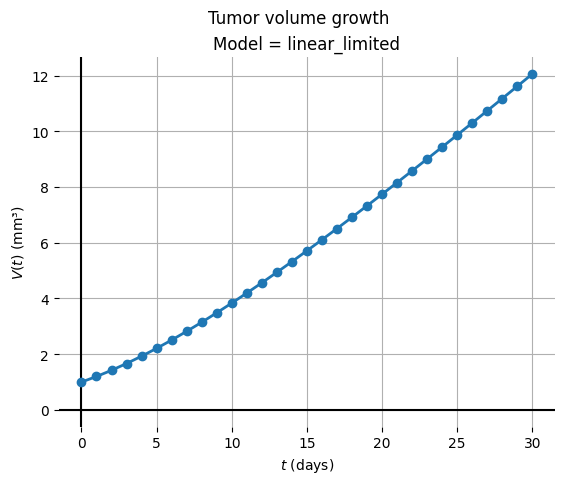

In [22]:
# Generating prediction according to linear limited growth
linear_limited_model = cgm(model = "linear_limited",
                       start_size = 1,
                       t_0 = 0,
                       t_end = 30,
                       growth_rate = 0.5,
                       step_size = 1,
                       a = 1.5)
linear_limited_prediction = linear_limited_model.predict()
print("Linear limited model prediction:", linear_limited_prediction)
linear_limited_model.plot(linear_limited_prediction)

Surface limited model prediction: [1, 2.0, 3.2, 4.497, 5.847, 7.229, 8.632, 10.05, 11.479, 12.916, 14.36, 15.81, 17.264, 18.722, 20.183, 21.646, 23.112, 24.581, 26.051, 27.523, 28.996, 30.47, 31.946, 33.423, 34.901, 36.38, 37.859, 39.34, 40.821, 42.303, 43.785, 45.268, 46.752, 48.236, 49.721, 51.206, 52.691, 54.177, 55.664, 57.15, 58.637, 60.124, 61.612, 63.1, 64.588, 66.077, 67.565, 69.054, 70.544, 72.033, 73.523]


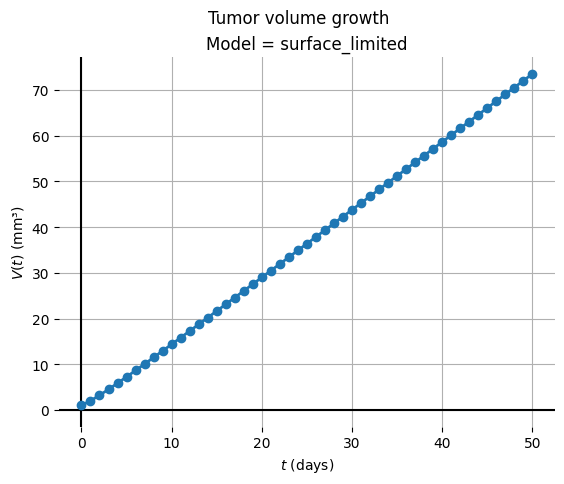

In [6]:
# Generating prediction according to surface limited growth
surface_limited_model = cgm(model = "surface_limited",
                       start_size = 1,
                       t_0 = 0,
                       t_end = 50,
                       growth_rate = 0.5,
                       step_size = 1,
                       a = 0.5)
surface_limited_prediction = surface_limited_model.predict()
print("Surface limited model prediction:", surface_limited_prediction)
surface_limited_model.plot(surface_limited_prediction)

Bertalanffy model prediction: [1, -0.75, 1.875, 1.613, 1.023, -0.663, 2.396, 2.655, 3.136, 3.986, 5.414, 7.706, 11.267, 16.7, 24.916, 37.283, 55.864, 83.756, 125.607, 188.393, 282.577, 423.858, 635.782, 953.669, 1430.501, 2145.75, 3218.623, 4827.934, 7241.901, 10862.852, 16294.277]


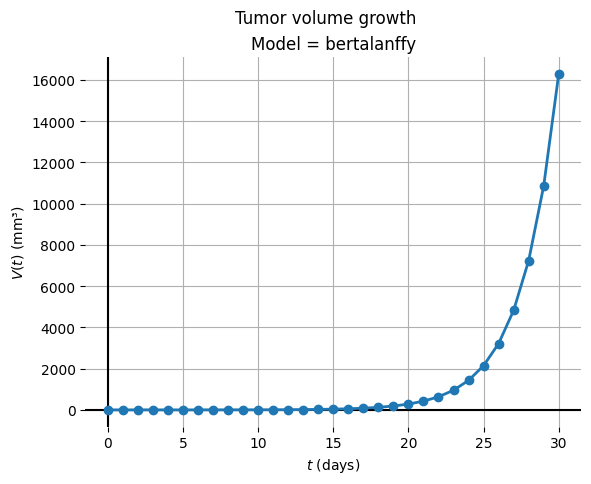

In [3]:
# Generating prediction according to Bertalanffy growth
bertalanffy_model = cgm(model = "bertalanffy",
                       start_size = 1,
                       t_0 = 0,
                       t_end = 30,
                       growth_rate = 0.5,
                       step_size = 1,
                       a = 1.5)
bertalanffy_prediction = bertalanffy_model.predict()
print("Bertalanffy model prediction:", bertalanffy_prediction)
bertalanffy_model.plot(bertalanffy_prediction)

Bertalanffy model prediction: [1, 2.956, 7.136, 14.083, 23.004, 31.934, 39.093, 43.903, 46.758, 48.325, 49.148, 49.571, 49.784, 49.892, 49.946, 49.973, 49.986, 49.993, 49.997, 49.998, 49.999, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]


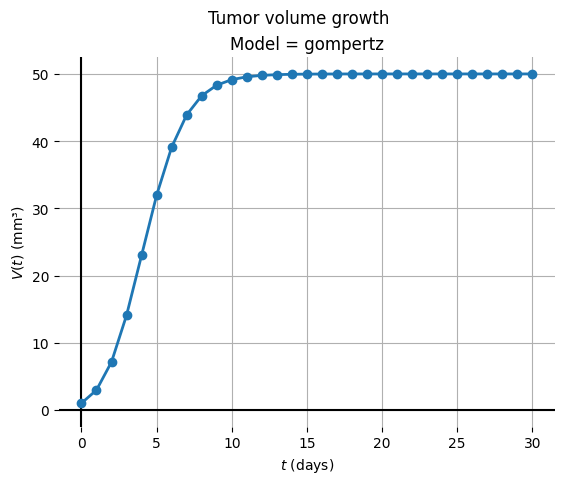

In [8]:
# Generating prediction according to Gompertz growth
gompertz_model = cgm(model = "gompertz",
                       start_size = 1,
                       t_0 = 0,
                       t_end = 30,
                       growth_rate = 0.5,
                       step_size = 1,
                       max_size = 50)
gompertz_prediction = gompertz_model.predict()
print("Bertalanffy model prediction:", gompertz_prediction)
gompertz_model.plot(gompertz_prediction)